In [1]:
import pandas as pd
import numpy as np

In [2]:
#read the csv file
df = pd.read_csv("X:/research paper-implementation/PJMW_hourly_preprocessed_LSTM.csv",parse_dates=['Datetime'], index_col='Datetime')

In [3]:
df

,PJMW_MW,hour,day_of_week,month
Datetime,,,,
2002-04-01 01:00:00,4374.0,1,0,4
2002-04-01 02:00:00,4306.0,2,0,4
2002-04-01 03:00:00,4322.0,3,0,4
2002-04-01 04:00:00,4359.0,4,0,4
2002-04-01 05:00:00,4436.0,5,0,4
...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,3,8
2018-08-02 21:00:00,6496.0,21,3,8
2018-08-02 22:00:00,6325.0,22,3,8


In [4]:
# MinMax Scaling
from sklearn.preprocessing import MinMaxScaler
features = ['PJMW_MW', 'hour', 'day_of_week', 'month']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Create scaled DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['Datetime'] = df.index

In [5]:
scaled_df

,PJMW_MW,hour,day_of_week,month,Datetime
0,0.426815,0.043478,0.000000,0.272727,2002-04-01 01:00:00
1,0.419348,0.086957,0.000000,0.272727,2002-04-01 02:00:00
2,0.421105,0.130435,0.000000,0.272727,2002-04-01 03:00:00
3,0.425167,0.173913,0.000000,0.272727,2002-04-01 04:00:00
4,0.433622,0.217391,0.000000,0.272727,2002-04-01 05:00:00
...,...,...,...,...,...
143231,0.665203,0.869565,0.500000,0.636364,2018-08-02 20:00:00
143232,0.659822,0.913043,0.500000,0.636364,2018-08-02 21:00:00
143233,0.641045,0.956522,0.500000,0.636364,2018-08-02 22:00:00
143234,0.593500,1.000000,0.500000,0.636364,2018-08-02 23:00:00


### Data Preprocessing with Lag Features

In [6]:
# Add lag features (1h, 3h, 24h, 168h)
lags = [1, 3, 24, 168]  # 1h, 3h, 24h, and 1-week lags
for lag in lags:
    scaled_df[f'lag_{lag}'] = scaled_df['PJMW_MW'].shift(lag)

# Add rolling statistics
scaled_df['rolling_24h_mean'] = scaled_df['PJMW_MW'].rolling(24).mean()
scaled_df['rolling_24h_std'] = scaled_df['PJMW_MW'].rolling(24).std()

# Drop NA values from lagging/rolling
scaled_df = scaled_df.dropna()
scaled_df.set_index('Datetime', inplace=True)

# Update features list
features.extend([f'lag_{lag}' for lag in lags])
features.extend(['rolling_24h_mean', 'rolling_24h_std'])
print("Final features:", features)

Final features: ['PJMW_MW', 'hour', 'day_of_week', 'month', 'lag_1', 'lag_3', 'lag_24', 'lag_168', 'rolling_24h_mean', 'rolling_24h_std']


In [7]:
scaled_df

,PJMW_MW,hour,day_of_week,month,lag_1,lag_3,lag_24,lag_168,rolling_24h_mean,rolling_24h_std
Datetime,,,,,,,,,,
2002-04-08 01:00:00,0.455364,0.043478,0.000000,0.272727,0.473372,0.537059,0.495772,0.426815,0.498177,0.026002
2002-04-08 02:00:00,0.444164,0.086957,0.000000,0.272727,0.455364,0.514330,0.479960,0.419348,0.496685,0.028040
2002-04-08 03:00:00,0.438564,0.130435,0.000000,0.272727,0.444164,0.473372,0.480674,0.421105,0.494931,0.030311
2002-04-08 04:00:00,0.443615,0.173913,0.000000,0.272727,0.438564,0.455364,0.481388,0.425167,0.493357,0.031979
2002-04-08 05:00:00,0.456023,0.217391,0.000000,0.272727,0.443615,0.444164,0.485561,0.433622,0.492126,0.032849
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,0.665203,0.869565,0.500000,0.636364,0.681454,0.683101,0.694960,0.754035,0.584413,0.083674
2018-08-02 21:00:00,0.659822,0.913043,0.500000,0.636364,0.665203,0.688591,0.668058,0.722082,0.584070,0.083332
2018-08-02 22:00:00,0.641045,0.956522,0.500000,0.636364,0.659822,0.681454,0.645108,0.703635,0.583901,0.083207


### Create Time-Series Sequences

In [8]:
import numpy as np

n_past = 24  # How many past time steps to use
n_future = 1  # How many steps ahead to predict

# Updated features with lags and rolling stats
features = [
    'PJMW_MW', 
    'hour', 
    'day_of_week', 
    'month',
    'lag_1',
    'lag_3', 
    'lag_24',
    'lag_168',
    'rolling_24h_mean',
    'rolling_24h_std'
]
target = 'PJMW_MW'  # Target remains the same

# Convert to numpy (using your exact structure)
data = scaled_df[features].values

X = []
y = []

for i in range(n_past, len(data) - n_future + 1):
    X.append(data[i - n_past:i])  # past 24 hours (now includes lag features)
    y.append(data[i + n_future - 1, 0])  # target value (PJMW_MW column)

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # Now should be (samples, 24, 10)
print("y shape:", y.shape)  # Should be (samples,)
print("Features used (in order):", features)

X shape: (143044, 24, 10)
y shape: (143044,)
Features used (in order): ['PJMW_MW', 'hour', 'day_of_week', 'month', 'lag_1', 'lag_3', 'lag_24', 'lag_168', 'rolling_24h_mean', 'rolling_24h_std']


In [9]:
# 1. Verify your data shapes
print("Original shapes:")
print(f"X shape: {X.shape}")  # Should be (143044, 24, 10)
print(f"y shape: {y.shape}")  # Should be (143044,)

Original shapes:
X shape: (143044, 24, 10)
y shape: (143044,)


### Train-Val-Test Split (Time-Based)

In [10]:
# Chronological split: 70% train, 20% test
train_size = int(len(X) * 0.70)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Verify no overlap
print(f"Train ends at: {scaled_df.index[train_size-1]}")
print(f"Test starts at: {scaled_df.index[train_size]}")

Train ends at: 2013-09-09 02:00:00
Test starts at: 2013-09-09 03:00:00


In [11]:
# 3. Create validation set from training data
val_size = int(len(X_train) * 0.2)
X_train, X_val = X_train[:-val_size], X_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]

In [12]:
# 4. Verify final shapes
print("\nFinal shapes:")
print(f"X_train: {X_train.shape} (should be (~80091, 24, 10))")
print(f"X_val: {X_val.shape} (should be (~20023, 24, 10))")
print(f"X_test: {X_test.shape} (should be (~42914, 24, 10))")


Final shapes:
X_train: (80104, 24, 10) (should be (~80091, 24, 10))
X_val: (20026, 24, 10) (should be (~20023, 24, 10))
X_test: (42914, 24, 10) (should be (~42914, 24, 10))


In [13]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# 5. Build model with correct input shape
model = Sequential([
    LSTM(64, input_shape=(n_past, len(features))),  # Must match (24, 10)
    Dropout(0.2),
    Dense(1) # the value is 1 # because we are predicting PJMW_MW
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

x:\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265 (75.25 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 3. Train with verified shapes
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    shuffle=False,
    verbose=1
)

print("\nTraining complete!")
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")

Epoch 1/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0100 - mae: 0.0710 - val_loss: 0.0022 - val_mae: 0.0361
Epoch 2/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0020 - mae: 0.0350 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 3/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 0.0015 - val_mae: 0.0303
Epoch 4/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 0.0012 - val_mae: 0.0276
Epoch 5/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 8.1763e-04 - mae: 0.0217 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 6/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 6.1210e-04 - mae: 0.0186 - val_loss: 9.5028e-04 - val_mae: 0.0243
Epoch 7/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4.9770e-04 - mae: 0.0166 - val_loss: 7.0880e-04 - val_mae: 0.0208
Epoch 8/50
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 3.8876e-04 - mae: 0.0145 - val_loss: 5.6311e-04 - val_mae: 0.0185
Epoc

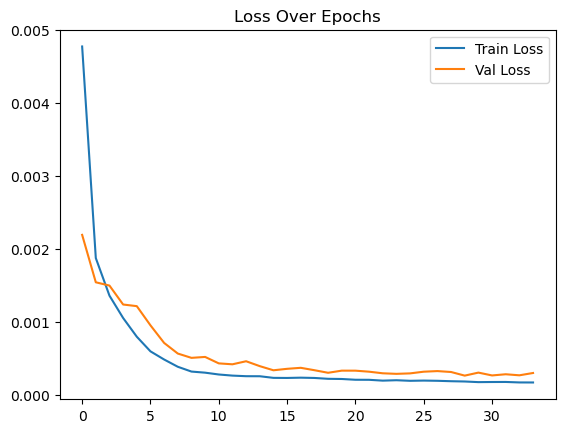

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

#Both decrease smoothly and converge (no divergence or spikes).
#validation loss is consistently lower than training loss, which could mean:
#Your validation set is easier to predict (check for data leakage).
#The model generalizes exceptionally well (rare but possible).

### Non Memory-Efficient Evaluation Code - might be run might be not

In [ ]:
#from sklearn.metrics import mean_squared_error, r2_score
#import numpy as np

# Get predictions
#y_pred = model.predict(X_test)

# Calculate metrics
#test_mae = np.mean(np.abs(y_test - y_pred))
#test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#test_r2 = r2_score(y_test, y_pred)

# Print scaled metrics
#print(f"Test MAE (scaled): {test_mae:.4f}")
#print(f"Test RMSE (scaled): {test_rmse:.4f}")
#print(f"Test R² (scaled): {test_r2:.4f}")


1342/1342 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


MemoryError: Unable to allocate 13.7 GiB for an array with shape (42914, 42914) and data type float64

### Memory-Efficient Evaluation Code

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics in one pass (memory efficient for large datasets)
def batch_predict_evaluate(model, X_test, y_test, batch_size=1000):
    y_pred = model.predict(X_test, batch_size=batch_size).flatten()
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Safe MAPE calculation
    epsilon = 1e-10  # Prevents division by zero
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
    
    return mae, rmse, mape, r2

# Get metrics
test_mae, test_rmse, test_mape, test_r2 = batch_predict_evaluate(model, X_test, y_test)

# Print scaled metrics
print(f"Test MAE (scaled): {test_mae:.4f}")
print(f"Test RMSE (scaled): {test_rmse:.4f}")
print(f"Test R² (scaled): {test_r2:.4f}")

# Convert to original scale
mw_range = df['PJMW_MW'].max() - df['PJMW_MW'].min()
print(f"Test MAE: {test_mae * mw_range:.2f} MW (scaled: {test_mae:.4f})")
print(f"Test RMSE: {test_rmse * mw_range:.2f} MW (scaled: {test_rmse:.4f})")
print(f"Test MAPE: {test_mape:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test MAE (scaled): 0.0128
Test RMSE (scaled): 0.0174
Test R² (scaled): 0.9762
Test MAE: 116.66 MW (scaled: 0.0128)
Test RMSE: 158.14 MW (scaled: 0.0174)
Test MAPE: 2.22%


1342/1342 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


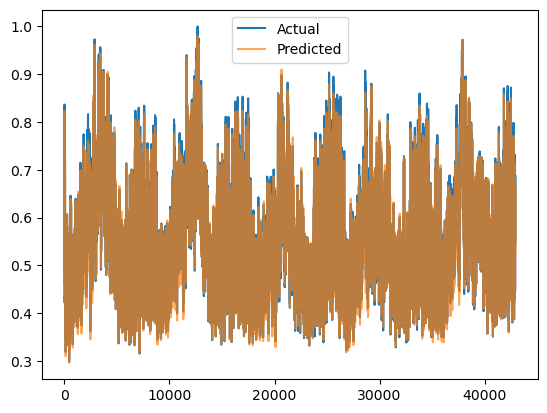

In [17]:
predictions = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.legend()
plt.show()

In [18]:
if X_train[-1, -1, 0] < X_val[0, -1, 0]:
    print("✅ No overlap (good)")
else:
    print("❌ Overlap (bad)")

✅ No overlap (good)
